# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function computes the probabilities that the new input belongs to all classes and
then returns the class that has the largest probability, i.e., makes a prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm, bernoulli, multinomial

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma^2)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html

Example: https://stackoverflow.com/questions/12412895/how-to-calculate-probability-in-a-normal-distribution-given-mean-standard-devi


**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [2]:
ALPHA = 1.0 # for additive smoothing

# https://pythonguides.com/python-scipy-stats-norm/
# https://stackoverflow.com/questions/60862145/what-is-the-point-of-norm-fit-in-scipy

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        self.mean, sd = norm.fit(X)
        self.var = 1e-6 if sd == 0 else np.square(sd)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        logpdf_norm = norm.logpdf(X_new, loc=self.mean, scale=np.sqrt(self.var))
        return logpdf_norm
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


# https://www.statology.org/numpy-count-unique/    

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # X is a vector with binary values
        # d = # of different values -> https://towardsdatascience.com/introduction-to-na%C3%AFve-bayes-classifier-fa59e3e24aaf
        # d = # of dimensions (features) -> https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece
        self.p = (sum(X)+ALPHA) /(len(X)+ALPHA*2)
        ##################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        logpmf_ber = bernoulli.logpmf(X_new, self.p)
        return logpmf_ber
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._d = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        values, counts = np.unique(X, return_counts=True)
        self._p = dict(zip(values, (counts + ALPHA)/(np.sum(counts) + ALPHA*self._d)))
        for i in range(self._d):
            if i not in self._p:
                self._p[i] = ALPHA / (np.sum(counts) + ALPHA*self._d)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        p = np.zeros(X_new.shape)
        for cat, val in self._p.items():
            idx = np.where(X_new == cat)
            p[idx] = val
        return np.log(p)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests:**
    
We will use the code below to test the correctness of your code.

In [3]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [4]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [5]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [6]:
# Your task is to implement the three functions of NBC. 
# USE MATRIX OVER LOOP
# log(probability)
# binary: [0,1] / categorical: [0,M-1]

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[], n=2):
        # TODO:
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # input = types of features -> initialise the classifier
        self.param = []
        self.num_categories = n
        for c in range(n):
            X_dstr_per_class=[]
            for j in feature_types:
                if j == 'b':
                    rv = BinFeatureParam()
                elif j == 'r':
                    rv = ContFeatureParam()
                else:
                    rv = CatFeatureParam(num_of_categories=n)
                X_dstr_per_class.append(rv)
            self.param.append(X_dstr_per_class) # c (class) x j (feature) matrix
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y): # estimate a parameter theta_jc for each class c & feature j
        # TODO:
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # check classes & counts of each class
        #_, counts = np.unique(y, return_counts=True)
        # prior probability: p(yi)
        #self.prior = counts/np.sum(counts)
        self.prior = np.zeros(self.num_categories)
        # sort X into categories
        for c in range(self.num_categories): # c = class
            X_by_class = X[y == c]
            for col in range(X.shape[1]): # j = feature
                Xj_given_c = X_by_class[:,col]
                self.param[c][col].estimate(Xj_given_c)
            self.prior[c] = np.sum(y == c)/y.size
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        prob_c = np.zeros((self.num_categories, X.shape[0]))

        for c in range(self.num_categories):
            prob_yc = np.zeros(X.shape[0])
            prob_Xc = np.zeros(X.shape[0])
            prob_yc += np.log(self.prior[c])

            for j in range(X.shape[1]): # for each feature
                Xnewj_c = self.param[c][j].get_log_probability(X[:,j])
                prob_Xc += Xnewj_c
            prob_c[c] = prob_yc + prob_Xc
        # choose the class with largest probability
        return np.argmax(prob_c, axis=0)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests**

We will use the code below to check your code.

In [7]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape # X = 150 rows * 4 columns / y categories = [0,1,2]
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], n=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [8]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

# values = np.unique(y)
# print(values) [0,1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16, n=2)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [9]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

# values = np.unique(y)
# print(values) [0 1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

nbc = NBC(feature_types=['c'] * 9, n=2)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat)

Accuracy: 0.6551724137931034
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


<ipython-input-2-ed24f158307d>:104: RuntimeWarning: divide by zero encountered in log
  return np.log(p)


## Logistic Regression

For logistic regression (LR), you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [10]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [11]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers

def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10): # repeat num_run times!
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = np.zeros(num_splits)
    tst_errs_lr = np.zeros(num_splits)
    
    for i in range(num_runs):
        # Split into the train & test datasets
        N, D = X.shape
        Ntrain = int(0.8 * N)
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]] # 10 splits!! 

        for split in range(num_splits):
            # tst_errs_nbc1 = tst_errs_lr1 = []

            N_split = Xtrain.shape[0]
            Ntrain_split = int(0.1*(split+1)*N_split)
            Xtrain_split = Xtrain[:Ntrain_split,:]
            ytrain_split = ytrain[:Ntrain_split]
            
            # NBC: fit & predict
            nbc.fit(Xtrain_split, ytrain_split)
            y_pred_nbc = nbc.predict(Xtest)

            # Logistic Regression: fit & predict
            lr.fit(Xtrain_split, ytrain_split)
            y_pred_lr = lr.predict(Xtest)
            
            # get test errors of the model
            tst_errs_nbc[split] += np.mean(y_pred_nbc != ytest)
            tst_errs_lr[split] += np.mean(y_pred_lr != ytest)
        
    tst_errs_nbc /= num_runs
    tst_errs_lr /= num_runs

    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [12]:
def makePlot(tst_errs_nbc, tst_errs_lr, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, tst_errs_nbc, label='Naive Bayes')
    plt.plot(xaxis_scale, tst_errs_lr, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

Categories in the iris dataset: [0 1 2]
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  
Checking for missing values: sep

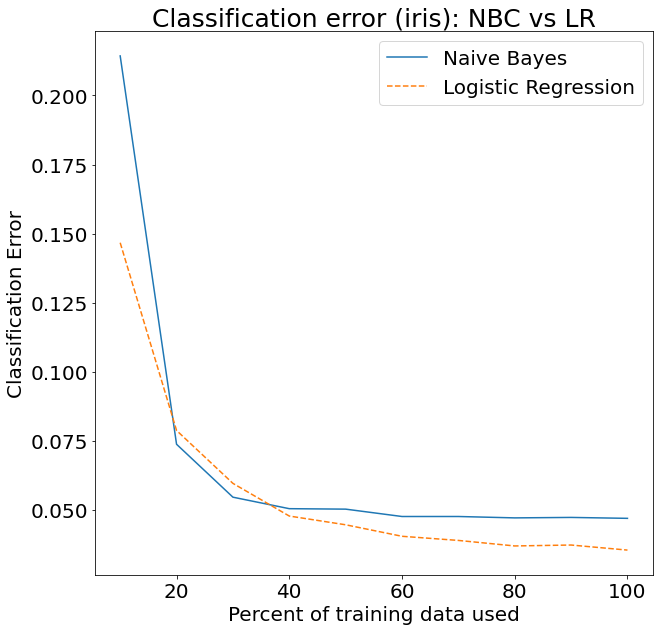

In [39]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
import warnings
warnings.filterwarnings('ignore')

iris = load_iris()

# Preparation of the dataset
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
categories = np.unique(df.target)
print(f'Categories in the iris dataset: {categories}')
print(df.describe()) # 4 columns -> continuous = 'r'
print(f'Checking for missing values: {df.isna().sum()}') # no missing values

X = iris.data
y = df.target

#classifier initializations
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], n=len(categories))
lr_iris=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_iris, lr_iris, X, y, num_runs=200, num_splits=10)

makePlot(tst_errs_nbc, tst_errs_lr, title="Classification error (iris): NBC vs LR")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

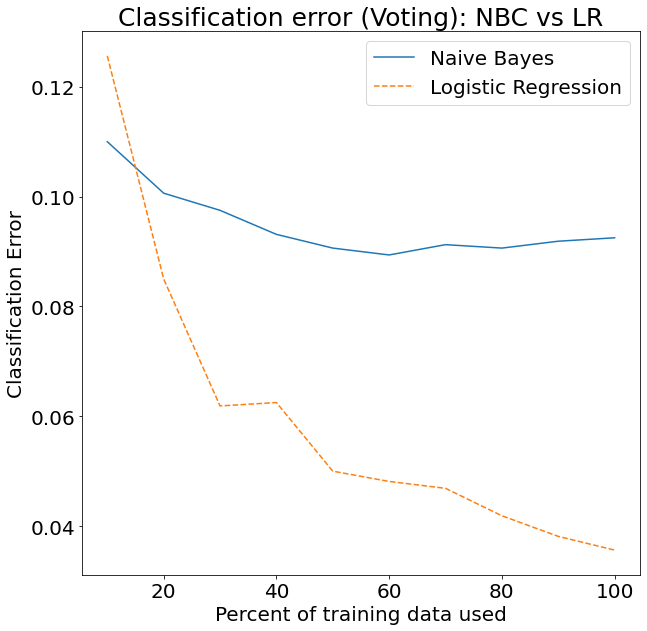

In [70]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('./datasets/voting.csv')

## preprocessing
# Drop missing values & take 100 data points
voting.info()
voting = voting.dropna()
voting = voting.sample(n = 100)

# Convert categorical variables into 0 & 1
voting = voting.replace(to_replace = ["y","n"], value = [1,0])
voting = voting.replace(to_replace = ["democrat","republican"], value = [1,0])
voting.reset_index(inplace=True, drop = True)

# Split the dataset into X & y
X = voting.drop(columns=['label']).to_numpy()
y = voting['label'].to_numpy()
classes = np.unique(y)

# # Compare the two classifiers 
nbc_voting = NBC(feature_types=['b']*16, n=len(classes))
lr_voting=LogisticRegression(max_iter=1000)
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc_voting, lr_voting, X, y, num_runs=80, num_splits=10)

# Plot the results
makePlot(tst_errs_nbc, tst_errs_lr, title="Classification error (Voting): NBC vs LR")
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

# Report on the preparation of datasets
`````
1. Iris
`````
Firstly, we converted the iris dataset into the pandas data frame. Then, we checked the overall structure of the data frame to decide whether each feature was continuous, binomial or multinomial. As the column target was an information about classes, we saved it separately at y. After scrutinising, there were three unique classes in y. We moved on to check for the missing values. It turned out that there were no missing values, so we analysed the dataset without dropping any rows or columns. Also, as there were four features, which were all continuous, the feature of all columns were set to 'r'.
After all, we applied both NBC and LogisticRegression to the iris dataset. It was observed that the Naive Bayes model was efficient till roughly 40% of the training data was used. However, the logistic regression model was better than the naive Bayes model regarding the error when using more than 40% of the training dataset.

`````
2. Voting
`````